In [1]:
# Import Libraries
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import re
import sys
import ast
import numpy as np

In [2]:
# Import the Movies Metadata
cwd = os.getcwd()

def get_cast(movie, metadata_df):
    if str(movie['tmdbId']).strip() != '' and len(metadata_df[metadata_df['tmdbId'] == movie['tmdbId']]) > 0:
        movie_casts = metadata_df[metadata_df['tmdbId'] == movie['tmdbId']].iloc[0]['casts']
    else:
        movie_casts = 'No Cast Specified'
    if movie_casts.strip() == '':
        movie_casts = 'No Cast Specified'
    return movie_casts


if not os.path.exists(os.path.join(cwd, 'data', 'processed', 'movie_actors_genres.csv')):
    movies = pd.read_csv(os.path.join(cwd, 'data', 'processed', 'movies.csv'), dtype={'tmdbId': str})
    movie_credits = pd.read_csv(os.path.join(cwd, 'data', 'credits.csv'), dtype={'id': str})
    movie_credits = movie_credits[movie_credits['id'].isin(movies['tmdbId'].unique().tolist())]
    print("Creating Cast List")
    casts_dict = {}
    casts_occurrences = []
    for (_, movie_info) in movie_credits.iterrows():
        casts_json_string = movie_info['cast']
        casts = ast.literal_eval(casts_json_string)
        
        for cast in casts:
            casts_occurrences.append(cast['name'])
            if not cast['name'] in casts_dict:
                casts_dict[cast['name']] = []
            casts_dict[cast['name']].append(movie_info['id'])
            
    top_actors  = pd.Series(casts_occurrences).value_counts()
    top_actors = top_actors[:200].keys().tolist()
    top_actors = {k: v for k, v in casts_dict.items() if k in top_actors}
    movie_actors_dict = {}
    for actor, movies_list in top_actors.items():
        for movie in movies_list:
            if not movie in movie_actors_dict:
                movie_actors_dict[movie] = []
            movie_actors_dict[movie].append(actor)
    movie_actors = [[k, '|'.join(v)] for k, v in movie_actors_dict.items()]
    movie_actors_df = pd.DataFrame(movie_actors, columns=['tmdbId', 'casts'])
    
    movies['casts'] = [get_cast(movie, movie_actors_df) for (_, movie) in movies.iterrows()]
        
    movies.to_csv(os.path.join(cwd, 'data', 'processed', 'movie_actors_genres.csv'), index=False)
    del movie_credits
    del casts_dict
    del casts_occurrences
    del top_actors
    del movie_actors_dict
    del movie_actors
    del movie_actors_df
    del movies

movies = pd.read_csv(os.path.join(cwd, 'data', 'processed', 'movie_actors_genres.csv'), dtype={'tmdbId': str})

print(f"Number of Movies: {len(movies)}")

Creating Cast List
Number of Movies: 36305


In [3]:
def count_actors(df, ref_col, actors_list):
    keyword_count = dict()
    for s in actors_list:
        keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords):
            continue
        for s in liste_keywords:
            if pd.notnull(s):
                keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k, v in keyword_count.items():
        keyword_occurences.append([k, v])
    keyword_occurences.sort(key=lambda x: x[1], reverse=True)
    return keyword_occurences, keyword_count

In [4]:
casts = set()
for s in movies['casts'].str.split('|').values:
    casts = casts.union(set(s))

In [5]:
cast_occurrence, dum = count_actors(movies, 'casts', casts)
cast_occurrence

[['No Cast Specified', 27271],
 ['Bess Flowers', 196],
 ['Christopher Lee', 115],
 ['Samuel L. Jackson', 115],
 ['John Wayne', 112],
 ['Frank Welker', 104],
 ['Donald Sutherland', 102],
 ['Michael Caine', 100],
 ['Robert De Niro', 100],
 ['Jackie Chan', 97],
 ['Steve Buscemi', 96],
 ['Gérard Depardieu', 96],
 ['John Carradine', 94],
 ['Christopher Walken', 92],
 ['John Goodman', 88],
 ['Harvey Keitel', 88],
 ['Bruce Willis', 87],
 ['John Hurt', 87],
 ['Susan Sarandon', 86],
 ['Dennis Hopper', 86],
 ['Morgan Freeman', 83],
 ['Willem Dafoe', 83],
 ['Robert Duvall', 83],
 ['Danny Trejo', 82],
 ['Keith David', 81],
 ['Irving Bacon', 80],
 ['Robin Williams', 79],
 ['Whoopi Goldberg', 79],
 ['Danny Glover', 78],
 ['Max von Sydow', 78],
 ['Gene Hackman', 77],
 ['Malcolm McDowell', 77],
 ['Liam Neeson', 77],
 ['Vincent Price', 76],
 ['Donald Pleasence', 76],
 ['John Turturro', 76],
 ['Eric Roberts', 75],
 ['Nicolas Cage', 75],
 ['John Cusack', 75],
 ['Christopher Plummer', 75],
 ['Stanley Tucc

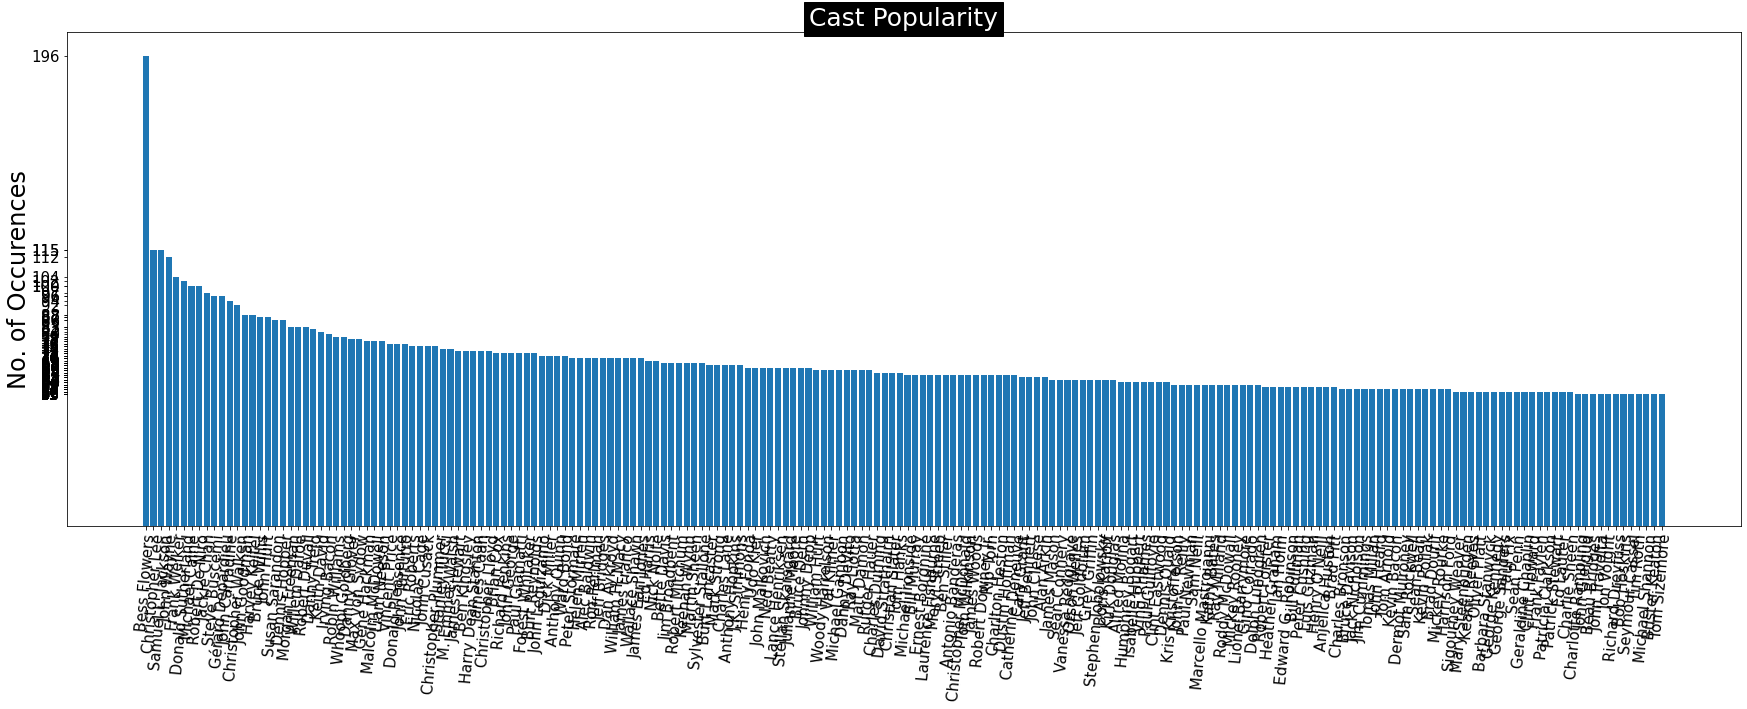

In [13]:
# Graph the Casts vs Occurrences
fig = plt.figure(1, figsize=(30, 20))
ax2 = fig.add_subplot(2, 1, 2)
y_axis = [i[1] for i in cast_occurrence[1:]]
y_label = [i[1] for i in cast_occurrence[1:]]
x_axis = [k for k, i in enumerate(cast_occurrence[1:])]
x_label = [i[0] for i in cast_occurrence[1:]]
plt.xticks(rotation=85, fontsize=15)
plt.yticks(fontsize=15)
plt.yticks(y_axis, y_label)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of Occurences", fontsize=24, labelpad=0)
ax2.bar(x_axis, y_axis, align='center')
plt.title("Cast Popularity", bbox={'facecolor': 'k', 'pad': 5}, color='w', fontsize=25)
plt.savefig(os.path.join(cwd, 'cast_occurrence.png'))

In [14]:
def count_genre(df, ref_col, genres_list):
    keyword_count = dict()
    for s in genres_list:
        keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords):
            continue
        for s in liste_keywords:
            if pd.notnull(s):
                keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k, v in keyword_count.items():
        keyword_occurences.append([k, v])
    keyword_occurences.sort(key=lambda x: x[1], reverse=True)
    return keyword_occurences, keyword_count

In [15]:
genres = set()
for s in movies['genres'].str.split('|').values:
    genres = genres.union(set(s))

In [16]:
genre_occurrence, dum = count_genre(movies, 'genres', genres)
genre_occurrence

[['Drama', 16811],
 ['Comedy', 10573],
 ['Thriller', 6359],
 ['Romance', 5655],
 ['Action', 5419],
 ['Horror', 3718],
 ['Crime', 3562],
 ['Documentary', 3000],
 ['Adventure', 2932],
 ['Science Fiction', 2448],
 ['Family', 2285],
 ['Mystery', 2052],
 ['No Genre Specified', 2033],
 ['Fantasy', 1866],
 ['Animation', 1502],
 ['Foreign', 1382],
 ['Music', 1305],
 ['History', 1185],
 ['War', 1113],
 ['Western', 790],
 ['TV Movie', 501]]

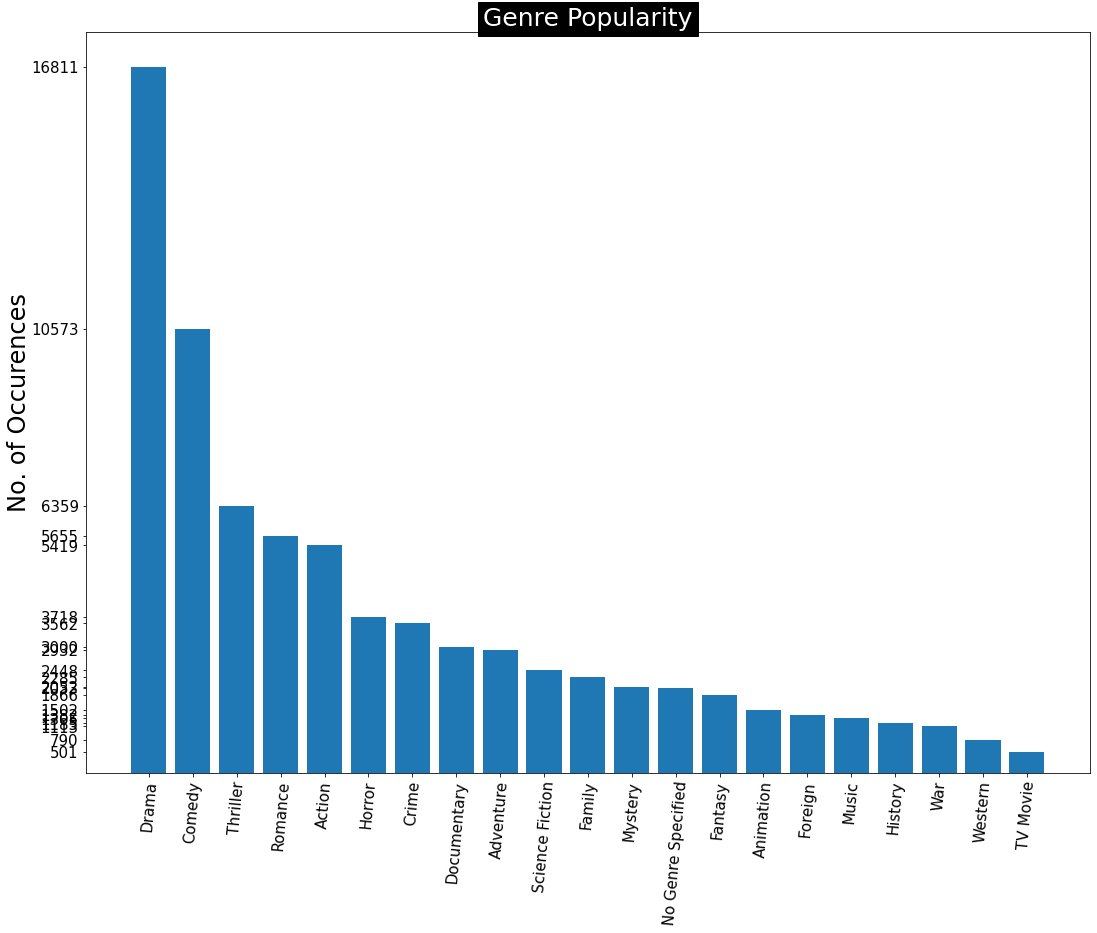

In [17]:
# Graph the Genres vs Occurrences
fig = plt.figure(1, figsize=(18, 30))
ax2 = fig.add_subplot(2, 1, 2)
y_axis = [i[1] for i in genre_occurrence]
y_label = [i[1] for i in genre_occurrence]
x_axis = [k for k, i in enumerate(genre_occurrence)]
x_label = [i[0] for i in genre_occurrence]
plt.xticks(rotation=85, fontsize=15)
plt.yticks(fontsize=15)
plt.yticks(y_axis, y_label)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of Occurences", fontsize=24, labelpad=0)
ax2.bar(x_axis, y_axis, align='center')
plt.title("Genre Popularity", bbox={'facecolor': 'k', 'pad': 5}, color='w', fontsize=25)
plt.savefig(os.path.join(cwd, 'movies_only_based_genre_occurrence.png'))

## Multi-Hot Encode Genres and Casts

In [18]:
from utils import multi_hot_encoder

encoded_movies = multi_hot_encoder(movies, 'genres', [genre for (genre, _) in genre_occurrence])

encoded_movies = multi_hot_encoder(encoded_movies, 'casts', [cast for (cast, _) in cast_occurrence])

encoded_movies

C:\Users\Hirad\miniconda3\envs\deep_learning\lib\site-packages\pandas\core\indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


,movieId,imdbId,tmdbId,genres,casts,Drama,Comedy,Thriller,Romance,Action,...,Beau Bridges,John Travolta,Jon Voight,Richard Dreyfuss,Bob Hoskins,Seymour Cassel,Tim Roth,Michael Shannon,Buster Keaton,Tom Sizemore
0,1,tt0114709,862,Animation|Comedy|Family,Tom Hanks|Wallace Shawn,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,tt0113497,8844,Adventure|Fantasy|Family,Robin Williams|Patricia Clarkson,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,tt0113228,15602,Romance|Comedy,Kevin Pollak,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,tt0114885,31357,Comedy|Drama|Romance,No Cast Specified,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,tt0113041,11862,Comedy,No Cast Specified,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36300,158009,tt0049979,127259,Drama,No Cast Specified,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36301,158011,tt0450061,388055,Documentary,Susan Sarandon,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36302,158013,tt0491795,245013,No Genre Specified,No Cast Specified,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36303,158015,tt1028561,97253,Documentary|Music,No Cast Specified,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Saving the encoded_movies matrix
encoded_movies.to_csv(os.path.join(cwd, 'data', 'processed', 'genre_cast_encoded_movies.csv'), index=False)

# Training the KD-Tree

Here we first train our KD-Tree model and the save the model for future use

In [30]:
from sklearn.neighbors import KDTree
from joblib import dump

print("Training the Tree")
tree_data = encoded_movies.drop(['imdbId', 'tmdbId', 'movieId', 'genres', 'casts'], axis=1)
tree_data = tree_data.values

tree = KDTree(tree_data, leaf_size=50)
dump(tree, os.path.join(cwd, 'saved_models', 'kd_tree_model.pkl'))
print("Done")

Training the Tree
Done
